In [2]:
import json
from os import path as osp
import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
pose = '/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/openpose_json/00000_00_keypoints.json'

with open(pose, 'r') as f:
  pose_label = json.load(f)
  pose_data = pose_label['people'][0]['pose_keypoints_2d']
  print(pose_data)
  pose_data = np.array(pose_data)
  pose_data = pose_data.reshape((-1, 3))[:, :2] # [25, 2]

[377.48, 144.978, 0.872396, 394.494, 312.201, 0.745711, 235.635, 326.396, 0.60995, 235.73, 584.28, 0.490828, 0, 0, 0, 555.965, 303.747, 0.616878, 570.027, 652.295, 0.681085, 482.199, 958.269, 0.691213, 317.888, 859.154, 0.371357, 224.403, 844.935, 0.313562, 0, 0, 0, 0, 0, 0, 408.568, 884.626, 0.324949, 0, 0, 0, 0, 0, 0, 334.941, 102.499, 0.870075, 416.971, 93.9887, 0.872983, 283.925, 113.831, 0.603164, 462.495, 79.7724, 0.904878, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
# Dresscode는 얼굴 부분이 없어서 키포인트가 적게 나옴 : 24개
# 그래도 사용할 수 있을까?
pose = '/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/upper_body/keypoints/000000_2.json'

with open(pose, 'r') as f:
  pose_label = json.load(f)
  pose_data = pose_label['keypoints']
  print(pose_data)
  pose_data = np.array(pose_data)
  pose_data = pose_data.reshape((-1, 3))[:, :2] # [24, 2]

[[176.0, 0.0, 0.7859817147254944, 0.0], [175.0, 60.0, 0.950710117816925, 1.0], [131.0, 60.0, 0.9103922247886658, 2.0], [122.0, 140.0, 0.9141194820404053, 3.0], [122.0, 209.0, 0.9568864703178406, 4.0], [219.0, 60.0, 0.8758295774459839, 5.0], [231.0, 137.0, 0.9045478105545044, 6.0], [231.0, 207.0, 0.9245232343673706, 7.0], [147.0, 211.0, 0.8522369861602783, 8.0], [146.0, 318.0, 0.921160876750946, 9.0], [151.0, 408.0, 0.8812177181243896, 10.0], [202.0, 209.0, 0.8160108327865601, 11.0], [201.0, 315.0, 0.8664158582687378, 12.0], [193.0, 408.0, 0.9237899780273438, 13.0], [165.0, 0.0, 0.5666932463645935, 14.0], [186.0, 0.0, 0.5773954391479492, 15.0], [153.0, 0.0, 0.5578122735023499, 16.0], [201.0, 0.0, 0.5469267964363098, 17.0]]


In [4]:
pose_data.shape

(25, 2)

In [41]:
im_parse = Image.open('/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/image-parse-v3/00001_00.png')

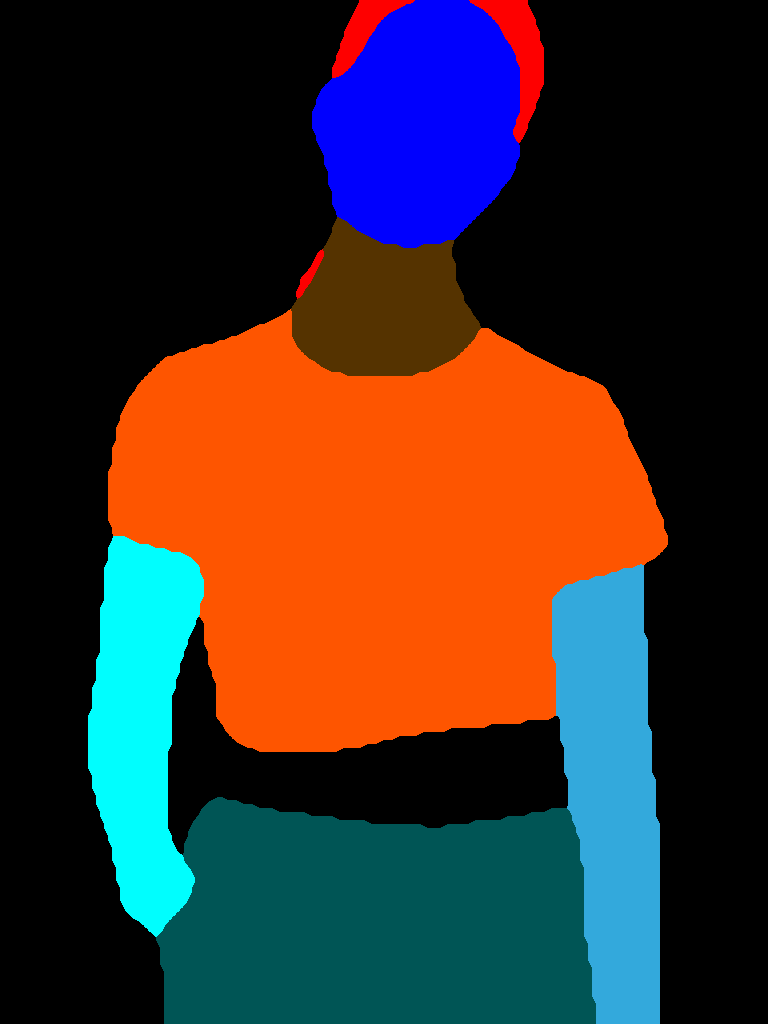

In [42]:
im_parse

In [43]:
label_array = np.array(im_parse)

In [44]:
np.unique(label_array)

array([ 0,  2,  5,  9, 10, 13, 14, 15], dtype=uint8)

In [45]:
parse_upper = ((label_array == 5).astype(np.float32) +
                    (label_array == 6).astype(np.float32) +
                    (label_array == 7).astype(np.float32))

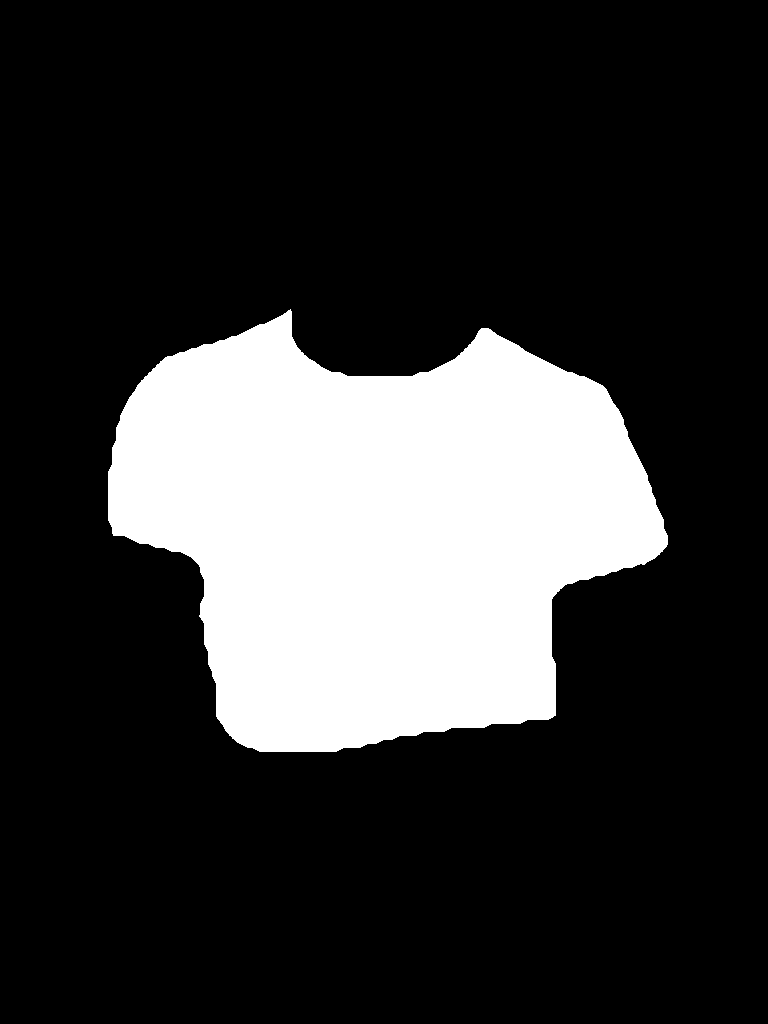

In [46]:
Image.fromarray(parse_upper.astype(np.uint8) * 255)

In [47]:
parse_neck = (label_array == 10).astype(np.float32)

In [48]:
agnostic = im_parse.copy()

In [49]:
agnostic.paste(0, None, Image.fromarray(np.uint8(parse_upper * 255), 'L'))

In [50]:
agnostic.paste(0, None, Image.fromarray(np.uint8(parse_neck * 255), 'L'))

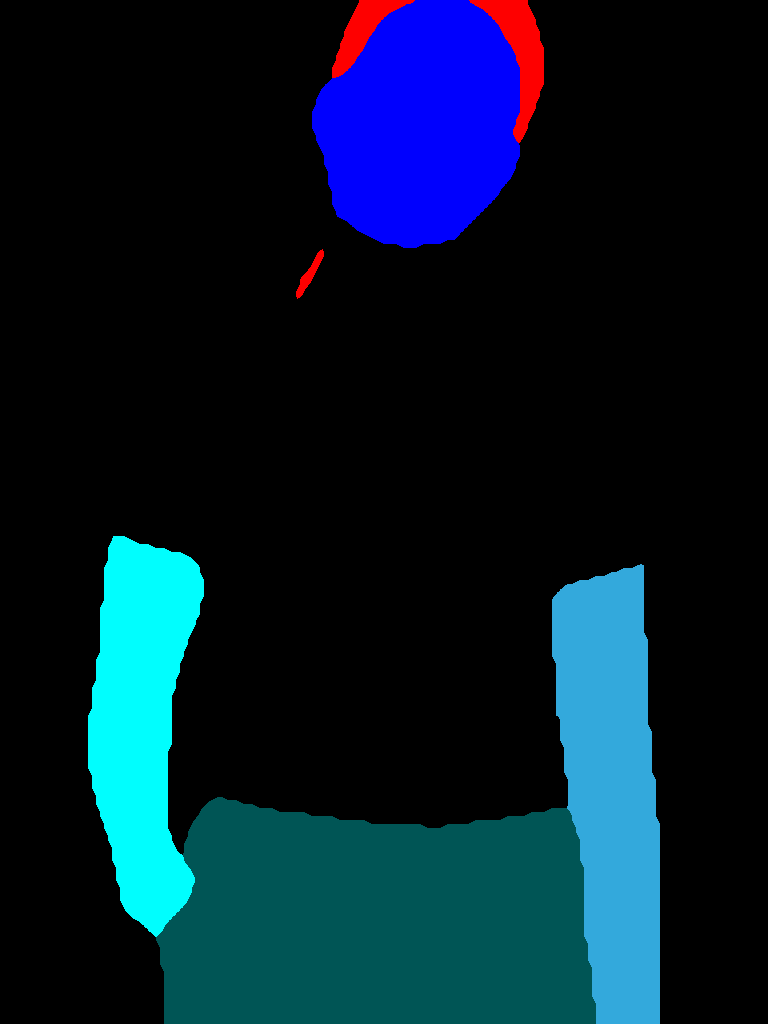

In [51]:
agnostic

In [52]:
# 14번 left-arm
w=768
h=1024
mask_arm = Image.new('L', (w, h), 'black')

In [53]:
parse_arm = (label_array == 14).astype(np.float32)

In [54]:
agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

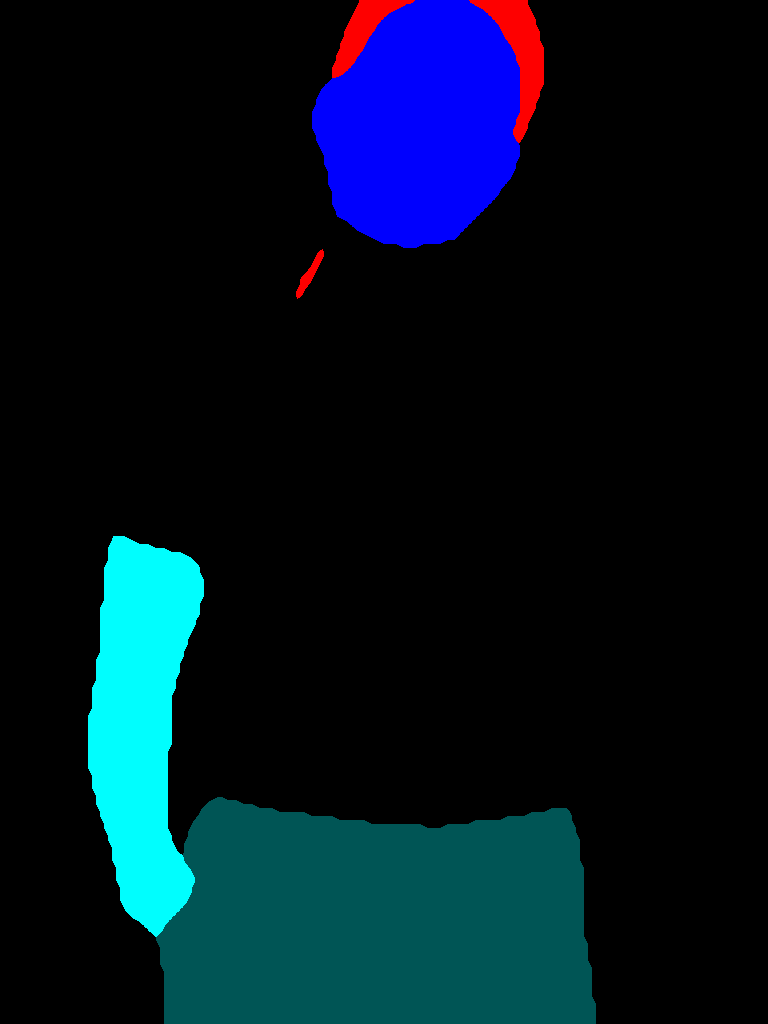

In [55]:
agnostic

In [58]:
# 15번 오른팔
parse_arm = (label_array == 15).astype(np.float32)
agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

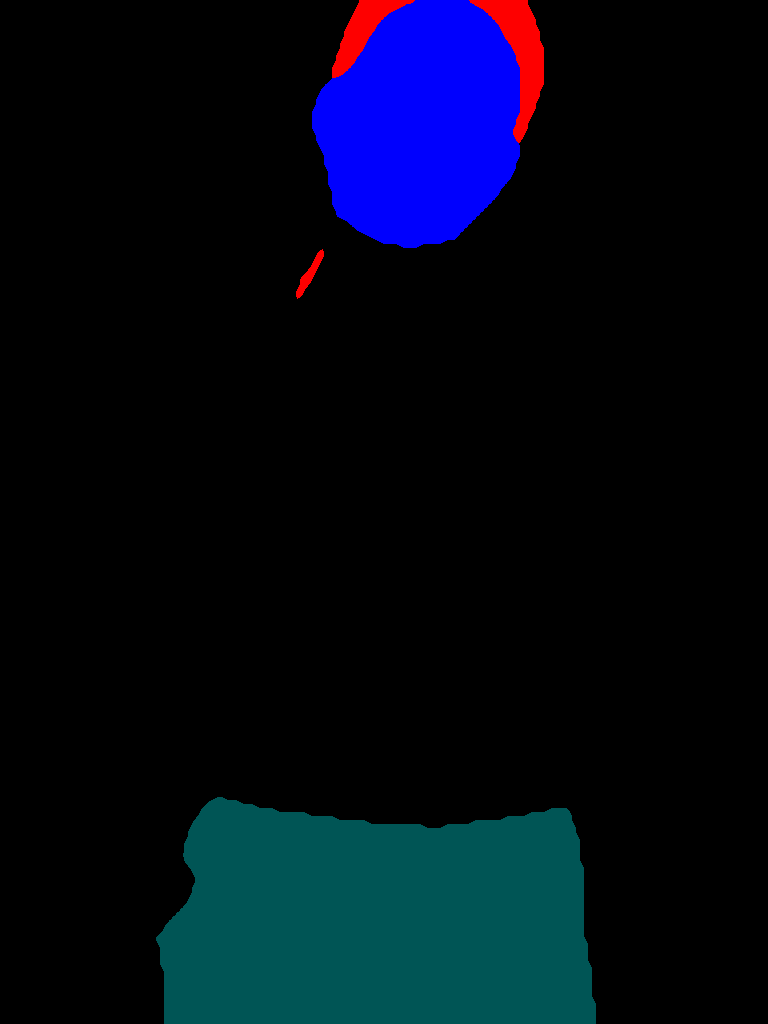

In [59]:
agnostic

In [ ]:
def get_im_parse_agnostic(im_parse, pose_data, w=768, h=1024):
    label_array = np.array(im_parse)
    
    # 지울 부분을 지정
    parse_upper = ((label_array == 5).astype(np.float32) +
                    (label_array == 6).astype(np.float32) +
                    (label_array == 7).astype(np.float32))
    parse_neck = (label_array == 10).astype(np.float32)

    r = 10
    agnostic = im_parse.copy()

    # mask arms
    # arm 부분이 occlusion을 일으키는 것을 감안해야 할듯
    # 14번 left-arm
    # 15번 right-arm
    # 2-Hair
    # 5-Upper-clothes
    # 6-Dress
    # 7-Coat
    for parse_id, pose_ids in [(14, [2, 5, 6, 7]), (15, [5, 2, 3, 4])]:
        # 14번에서 [2,5,6,7]
        mask_arm = Image.new('L', (w, h), 'black')
        mask_arm_draw = ImageDraw.Draw(mask_arm)
        i_prev = pose_ids[0] # i_prev 처음엔 2
        for i in pose_ids[1:]:
            # i_prev가 keypoint를 나타내는 듯
            # 키포인트 값이 없으면 무시
            if (pose_data[i_prev, 0] == 0.0 and pose_data[i_prev, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue

            # key point가 있는 곳 두 점을 이어서 라인을 만듬
            mask_arm_draw.line([tuple(pose_data[j]) for j in [i_prev, i]], 'white', width=r*10) # [2, 5]
            pointx, pointy = pose_data[i]
            radius = r*4 if i == pose_ids[-1] else r*15
            mask_arm_draw.ellipse((pointx-radius, pointy-radius, pointx+radius, pointy+radius), 'white', 'white')
            i_prev = i
        parse_arm = (np.array(mask_arm) / 255) * (label_array == parse_id).astype(np.float32)
        agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

    # mask torso & neck
    agnostic.paste(0, None, Image.fromarray(np.uint8(parse_upper * 255), 'L'))
    agnostic.paste(0, None, Image.fromarray(np.uint8(parse_neck * 255), 'L'))

    return agnostic


if __name__ =="__main__":
    data_path = './test'
    output_path = './test/parse'
    
    os.makedirs(output_path, exist_ok=True)
    
    for im_name in tqdm(os.listdir(osp.join(data_path, 'image'))):
        
        # load pose image
        pose_name = im_name.replace('.jpg', '_keypoints.json')
        
        try:
            with open(osp.join(data_path, 'openpose_json', pose_name), 'r') as f:
                pose_label = json.load(f)
                pose_data = pose_label['people'][0]['pose_keypoints_2d']
                pose_data = np.array(pose_data)
                pose_data = pose_data.reshape((-1, 3))[:, :2]
        except IndexError:
            print(pose_name)
            continue

        # load parsing image
        parse_name = im_name.replace('.jpg', '.png')
        im_parse = Image.open(osp.join(data_path, 'image-parse-v3', parse_name))

        agnostic = get_im_parse_agnostic(im_parse, pose_data)
        
        agnostic.save(osp.join(output_path, parse_name))